In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import matplotlib as mpl
import sys
from math import *
from scipy.stats import binned_statistic
import inspect
from Bio import SeqIO
from pathlib import Path
sns.set_theme(style="white", context="talk")
import glob
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import itertools
from scipy import stats
from scipy.stats import pearsonr



from utils_benchmark import * 
#test()

sns.set_context("talk")


def get_stats(scores_df, summary_homfam_exthomfam):
    stats_alignments = pd.merge(scores_df, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
    stats_alignments["approach"] = stats_alignments[["method", "bucket_size", "master_msa", "slave_msa", "dynamicX_val", "align_method", "tree_method"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    stats_alignments["approach"] = stats_alignments.approach.apply(lambda val: val.replace("_nan",""))
    stats_alignments["fam_approach"] = stats_alignments["family"]+"_"+stats_alignments["approach"]
    stats_alignments.tc = pd.to_numeric(stats_alignments.tc)
    return(stats_alignments)
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

In [2]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"
seqs_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/refs/"
# Load reference stats 
stats_alignments_ref= pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "stats_alignments_refs.csv"))
summary_homfam_merged_tosave = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_homfam_with_refs.csv"))

# Extract AF2 info for references only # Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
# Load datasets informations (Homfam + extHomfam)
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})


In [3]:
# Extract all sequences in reference 
summary_ref_af2 = pd.DataFrame()
for f in listdir(seqs_dir):
     if f.endswith("fa"):
        fasta_sequences = SeqIO.parse(open(os.path.join(seqs_dir,f)),'fasta')
        for fasta in fasta_sequences:
            seq_id = [fasta.id.replace("/","_")]
            l = len(fasta.seq.replace("-", ""))
            entry = pd.DataFrame({'sequence': seq_id,"length":l, "name": [f.replace("-ref.fa","").strip()]})
            summary_ref_af2 =  pd.concat([summary_ref_af2, entry], ignore_index = True)
summary_ref_af2["subset"] = "ref"
summary_ref_af2["family"] = summary_ref_af2.name
summary_ref_af2 = summary_ref_af2.merge(af2, on = ["sequence", "family"])
af2_homfam_summary = summary_ref_af2.groupby(['family',"benchmarking_dataset"]).agg({'plddt': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "benchmarking_dataset", "plddt_mean", "plddt_min", "plddt_max"], axis=1)

summary_homfam_merged_tosave["family"] = summary_homfam_merged_tosave.familcombined
summary_ref = pd.merge(summary_homfam_merged_tosave,af2_homfam_summary)

In [4]:
# Define dataset 
dataset = "homfam"
scores_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/score/")

scores = pd.DataFrame()
for score_name in os.listdir(scores_dir):
    score_file = os.path.join(scores_dir,score_name)
    # Parse file
    if score_file.endswith(".scores"):
        # only keep references
        if "-ref" in score_file:
            score_df = pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1)
            scores = pd.concat([scores, score_df])
scores = scores.iloc[:,0:4]
scores.columns = ['name', 'sp', 'tc', 'column']

In [5]:
# -------------------------
#      Regressive
# -------------------------
regressive_scores = scores[scores.name.str.contains("regressive")]
regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Progressive
# -------------------------
progressive_scores = scores[scores.name.str.contains("progressive")]
progressive_scores[["family", "method", "align_method", "tree_method"]] = progressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Dyanmic
# -------------------------
dynamic_scores = scores[scores.name.str.contains("dynamic")]
dynamic_scores[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val","master_msa", "slave_msa", "tree_method"]] = dynamic_scores.name.str.split(".", expand = True)


# --------------   summary all -----------------
scores_df = pd.concat([regressive_scores, progressive_scores, dynamic_scores], ignore_index=True, sort=False)

scores_df.family = scores_df.family.str.replace("-ref","")
scores_df["benchmarking_dataset"] = dataset

stats_alignments_ref = get_stats(scores_df, summary_homfam_exthomfam)

df = stats_alignments_ref
df.nref = df.n_sequences * df.perc_ref_total /100 

df = pd.merge(df, summary_ref, on = "family")

/tmp/ipykernel_25146/3451490122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
/tmp/ipykernel_25146/3451490122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
/tmp/ipykernel_25146/3451490122.py:5: SettingWithCopyWarning: 

In [6]:
# Comparison 1: DYNAMIC w/ 3D
df_dyn_3d = df[df.approach == "dynamic_50_tcoffee_msa_famsa_msa_100000000_FAMSA-medoid"]
#df_dyn_3d["nref"] = df_dyn_3d.n_sequences * df_dyn_3d.perc_ref_total /100 

# Comparison 2: DYNAMIC w/ FAMSA 
df_dyn_famsa = df[df.approach == "dynamic_50_famsa_msa_famsa_msa_100000000_FAMSA-medoid"]

# Comparison 3: PROGRESSIVE w/ 3D 
df_prog_3d = df[df.approach == "progressive_3DCOFFEE_FAMSA-medoid"]
df_prog_3d_mbed = df[df.approach == "progressive_3DCOFFEE_MBED"]

# Comparison 3: PROGRESSIVE w/ 3D 
df_prog_3d_probapair = df[df.approach == "progressive_PROBAPAIR_FAMSA-medoid"]
df_prog_3d_probapair_mbed = df[df.approach == "progressive_PROBAPAIR_MBED"]

# For sanity checks, MBED 
# df_prog_3d_expresso = df[df.approach == "progressive_EXPRESSOREAL_MBED"]
df_prog_3d_expresso = df[df.approach == "progressive_3DCOFFEEEXPERIMENTAL_MBED"]
df_prog_3dcoffee = df[df.approach == "progressive_3DCOFFEE_MBED"]
df_prog_famsa = df[df.approach == "progressive_FAMSA_MBED"]


# Comparison 4: PROGRESSIVE w/ FAMSA
df_prog_famsa_medoid = df[df.approach == "progressive_FAMSA_FAMSA-medoid"]


df_d_r = pd.merge(df_prog_3dcoffee, df_prog_3d_probapair_mbed, on = ["family"] )
df_d_r["diff_tc"] = df_d_r.tc_x - df_d_r.tc_y 
df_d_r["diff_sp"] = df_d_r.sp_x - df_d_r.sp_y 
df_d_r["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r.tc_y) 
df_d_r.columns = [c.replace("_x", "_3D") for c in list(df_d_r.columns)]
df_d_r.columns = [c.replace("_y", "_FAMSA") for c in list(df_d_r.columns)]



df_d_r_exp = pd.merge(df_prog_3d_expresso, df_prog_3d_probapair_mbed, on = ["family"] )
df_d_r_exp["diff_tc"] = df_d_r_exp.tc_x - df_d_r_exp.tc_y 
df_d_r_exp["diff_sp"] = df_d_r_exp.sp_x - df_d_r_exp.sp_y 
df_d_r_exp["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r_exp.tc_y) 
df_d_r_exp.columns = [c.replace("_x", "_3D") for c in list(df_d_r_exp.columns)]
df_d_r_exp.columns = [c.replace("_y", "_FAMSA") for c in list(df_d_r_exp.columns)]

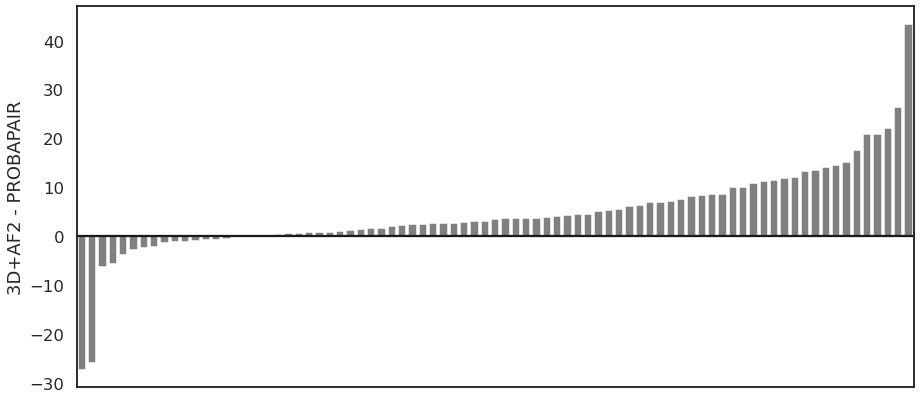

In [7]:
f, (ax1) = plt.subplots(1, 1, figsize=(15, 7), sharex=True)
# Center the data to make it diverging
sns.barplot(x=df_d_r.diff_sp, y=df_d_r.diff_sp, color ="grey", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set(ylabel="3D+AF2 - PROBAPAIR", xlabel = "", xticklabels="")
plt.show()

# Which is the degree of similarity in each family? 

In [8]:
# ---------------------------------------------------------
# Get SIMILARITY per family 
# Get number of sequences per family (and store for future notebooks)
# ---------------------------------------------------------

sims = os.path.join(evaluation_dir,"homfam/evaluation/sim/*FAMSA.MBED.sim")
sim_df = pd.DataFrame()

for file in list(glob.glob(sims)):
    full_name = file.split(sep = "/")[-1].replace(".sim", "")
    file_opened = open(file, "r")
    tot_line = [line.split() for line in file_opened if line.startswith('TOT')]
    entry = pd.DataFrame({'name': [full_name],"sim_tot": tot_line[0][3]})
    sim_df =  pd.concat([sim_df, entry], ignore_index = True)
# sim_df.head()

In [9]:
sim_df[["family_extended", "general_method", "method", "tree"]] = sim_df.name.str.split(".",expand = True)
sim_df["family"] = sim_df.family_extended.str.split("-ref",expand=True)[0]
sim_df.sim_tot = sim_df.sim_tot.astype(float)

In [10]:
references = sim_df[sim_df.family_extended.str.contains("-ref")]
full = sim_df[ ~sim_df.family_extended.str.contains("-ref")]

In [13]:
references

,name,sim_tot,family_extended,general_method,method,tree,family
0,adh-ref.progressive.FAMSA.MBED,64.09,adh-ref,progressive,FAMSA,MBED,adh
1,ghf13-ref.progressive.FAMSA.MBED,26.88,ghf13-ref,progressive,FAMSA,MBED,ghf13
2,gluts-ref.progressive.FAMSA.MBED,39.50,gluts-ref,progressive,FAMSA,MBED,gluts
3,kunitz-ref.progressive.FAMSA.MBED,38.47,kunitz-ref,progressive,FAMSA,MBED,kunitz
4,subt-ref.progressive.FAMSA.MBED,39.78,subt-ref,progressive,FAMSA,MBED,subt
...,...,...,...,...,...,...,...
89,sdr-ref.progressive.FAMSA.MBED,22.85,sdr-ref,progressive,FAMSA,MBED,sdr
90,rrm-ref.progressive.FAMSA.MBED,22.36,rrm-ref,progressive,FAMSA,MBED,rrm
91,mmp-ref.progressive.FAMSA.MBED,55.05,mmp-ref,progressive,FAMSA,MBED,mmp
92,phc-ref.progressive.FAMSA.MBED,37.09,phc-ref,progressive,FAMSA,MBED,phc


<AxesSubplot:xlabel='sim_tot', ylabel='Count'>

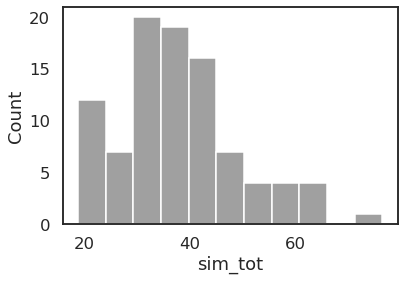

In [11]:
sns.histplot(references, x = "sim_tot")

# Now same lot as above but color with binned similarity 

In [13]:
df_d_r = df_d_r.merge(references, on = "family")

In [14]:
bins = [0, 20,40,60,70,90,100]
df_d_r["sim"] = pd.cut(df_d_r['sim_tot'], bins)
df_d_r.sim_tot = df_d_r.sim_tot.astype(float)

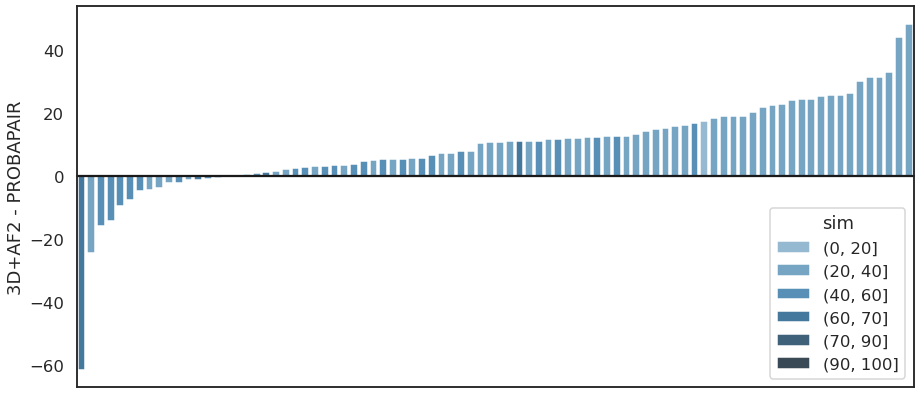

In [15]:
df_d_r_neg = df_d_r[df_d_r.diff_sp < 0]
df_d_r_neg = df_d_r

f, (ax1) = plt.subplots(1, 1, figsize=(15, 7), sharex=True)
# Center the data to make it diverging
cm = sns.color_palette("dark:salmon_r", as_cmap=True)
sns.barplot(x=df_d_r_neg.diff_tc, y=df_d_r_neg.diff_tc, ax=ax1, hue = df_d_r_neg.sim, dodge=False, palette = "Blues_d")

ax1.axhline(0, color="k", clip_on=False)
ax1.set(ylabel="3D+AF2 - PROBAPAIR", xlabel = "", xticklabels="")
plt.show()

In [16]:
df_d_r[df_d_r.diff_sp < -10]

,name_3D,sp_3D,tc_3D,column_3D,family,method_3D,bucket_size_3D,align_method_3D,tree_method_3D,dynamicX_label_3D,...,diff_tc,diff_sp,perc_change_tc,name,sim_tot,family_extended,general_method,method,tree,sim
34,rhv-ref.progressive.3DCOFFEE.MBED,57.0,33.3,41.7,rhv,progressive,NaN,3DCOFFEE,MBED,NaN,...,-24.3,-27.3,-42.187500,rhv-ref.progressive.FAMSA.MBED,33.28,rhv-ref,progressive,FAMSA,MBED,"(20, 40]"
49,bowman-ref.progressive.3DCOFFEE.MBED,71.8,28.6,23.8,bowman,progressive,NaN,3DCOFFEE,MBED,NaN,...,-61.4,-25.9,-68.222222,bowman-ref.progressive.FAMSA.MBED,64.12,bowman-ref,progressive,FAMSA,MBED,"(60, 70]"


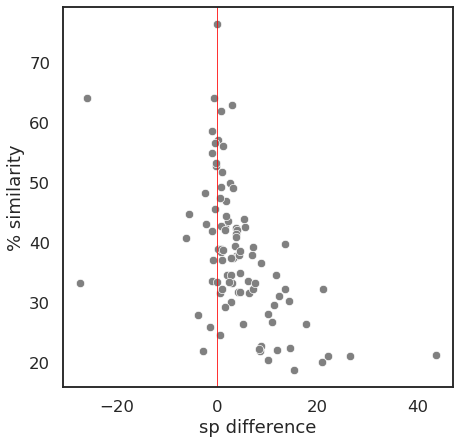

In [17]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=df_d_r_neg, x="diff_sp", y="sim_tot", s = 70)
ax.set(ylabel = "% similarity", xlabel = "sp difference")
#.set(xlim=(0,100),ylim=(0,1))
plt.axvline(0, color='red', linewidth = 0.8)


In [18]:
SIMILARITY_THRESHOLD = 40
dissimilar_references = df_d_r[df_d_r.sim_tot < SIMILARITY_THRESHOLD]
dissimilar_references_notgood = dissimilar_references[dissimilar_references.sp_FAMSA < 90]

In [19]:
dissimilar_references_notgood[dissimilar_references_notgood.diff_sp < 0 ]

,name_3D,sp_3D,tc_3D,column_3D,family,method_3D,bucket_size_3D,align_method_3D,tree_method_3D,dynamicX_label_3D,...,diff_tc,diff_sp,perc_change_tc,name,sim_tot,family_extended,general_method,method,tree,sim
34,rhv-ref.progressive.3DCOFFEE.MBED,57.0,33.3,41.7,rhv,progressive,NaN,3DCOFFEE,MBED,NaN,...,-24.3,-27.3,-42.1875,rhv-ref.progressive.FAMSA.MBED,33.28,rhv-ref,progressive,FAMSA,MBED,"(20, 40]"


In [20]:
dissimilar_references_notgood

,name_3D,sp_3D,tc_3D,column_3D,family,method_3D,bucket_size_3D,align_method_3D,tree_method_3D,dynamicX_label_3D,...,diff_tc,diff_sp,perc_change_tc,name,sim_tot,family_extended,general_method,method,tree,sim
2,KAS-ref.progressive.3DCOFFEE.MBED,94.5,85.2,89.8,KAS,progressive,NaN,3DCOFFEE,MBED,NaN,...,12.0,6.3,16.393443,KAS-ref.progressive.FAMSA.MBED,31.72,KAS-ref,progressive,FAMSA,MBED,"(20, 40]"
4,p450-ref.progressive.3DCOFFEE.MBED,84.1,47.1,60.9,p450,progressive,NaN,3DCOFFEE,MBED,NaN,...,14.2,10.1,43.161094,p450-ref.progressive.FAMSA.MBED,20.50,p450-ref,progressive,FAMSA,MBED,"(20, 40]"
5,ghf5-ref.progressive.3DCOFFEE.MBED,81.7,48.1,66.3,ghf5,progressive,NaN,3DCOFFEE,MBED,NaN,...,17.5,15.2,57.189542,ghf5-ref.progressive.FAMSA.MBED,18.82,ghf5-ref,progressive,FAMSA,MBED,"(0, 20]"
9,flav-ref.progressive.3DCOFFEE.MBED,93.1,79.4,82.7,flav,progressive,NaN,3DCOFFEE,MBED,NaN,...,12.5,4.6,18.684604,flav-ref.progressive.FAMSA.MBED,35.04,flav-ref,progressive,FAMSA,MBED,"(20, 40]"
12,TNF-ref.progressive.3DCOFFEE.MBED,95.2,83.4,88.6,TNF,progressive,NaN,3DCOFFEE,MBED,NaN,...,25.4,12.2,43.793103,TNF-ref.progressive.FAMSA.MBED,31.13,TNF-ref,progressive,FAMSA,MBED,"(20, 40]"
17,mofe-ref.progressive.3DCOFFEE.MBED,90.0,77.2,81.5,mofe,progressive,NaN,3DCOFFEE,MBED,NaN,...,22.9,14.2,42.173112,mofe-ref.progressive.FAMSA.MBED,30.33,mofe-ref,progressive,FAMSA,MBED,"(20, 40]"
22,ldh-ref.progressive.3DCOFFEE.MBED,94.1,70.0,79.2,ldh,progressive,NaN,3DCOFFEE,MBED,NaN,...,11.1,4.2,18.845501,ldh-ref.progressive.FAMSA.MBED,31.81,ldh-ref,progressive,FAMSA,MBED,"(20, 40]"
31,ace-ref.progressive.3DCOFFEE.MBED,90.1,75.6,80.0,ace,progressive,NaN,3DCOFFEE,MBED,NaN,...,8.0,2.8,11.834320,ace-ref.progressive.FAMSA.MBED,37.43,ace-ref,progressive,FAMSA,MBED,"(20, 40]"
32,sdr-ref.progressive.3DCOFFEE.MBED,89.8,48.6,63.9,sdr,progressive,NaN,3DCOFFEE,MBED,NaN,...,14.8,8.7,43.786982,sdr-ref.progressive.FAMSA.MBED,22.85,sdr-ref,progressive,FAMSA,MBED,"(20, 40]"
34,rhv-ref.progressive.3DCOFFEE.MBED,57.0,33.3,41.7,rhv,progressive,NaN,3DCOFFEE,MBED,NaN,...,-24.3,-27.3,-42.187500,rhv-ref.progressive.FAMSA.MBED,33.28,rhv-ref,progressive,FAMSA,MBED,"(20, 40]"


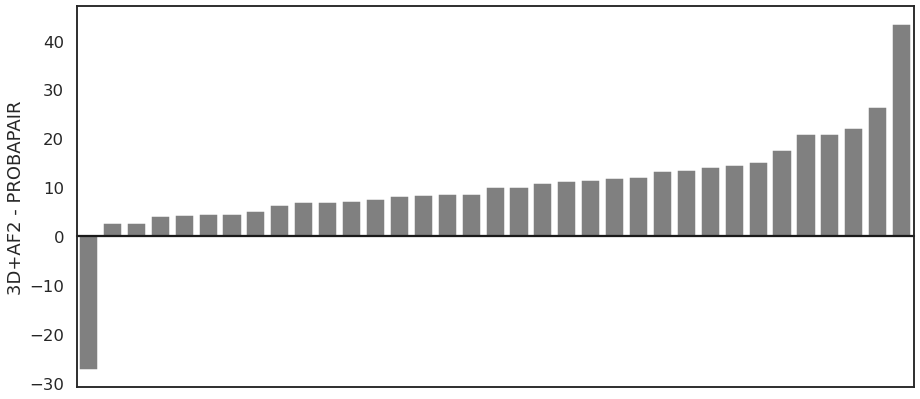

In [20]:
f, (ax1) = plt.subplots(1, 1, figsize=(15, 7), sharex=True)
# Center the data to make it diverging
cm = sns.color_palette("dark:salmon_r", as_cmap=True)
sns.barplot(x=dissimilar_references_notgood.diff_sp, y=dissimilar_references_notgood.diff_sp, ax=ax1, dodge=False, color = "grey")

ax1.axhline(0, color="k", clip_on=False)
ax1.set(ylabel="3D+AF2 - PROBAPAIR", xlabel = "", xticklabels="")
plt.show()

# Check TC workflow

In [21]:
problematic_families_list = df_d_r[df_d_r.diff_sp < 0].family

In [24]:
','.join(problematic_families_list)

'cryst,msb,HLH,LIM,oxidored_q6,serpin,toxin,int,ins,rhv,myb_DNA-binding,hr,ChtBD,tms,bowman,mmp,tgfb,adh,phc'

In [235]:
# From CSV parse in df the results of the tcs workflow
def get_df_tcs_wf(file): 
    df = pd.read_csv(file, header = None)
    df[["sequence", "tcs_seq"]] = df[1].str.split(":", expand = True)
    df = df.rename(columns = { 0: "tcs", 2: "iteration", 3:"sp", 4:"tc"})
    df = df.drop([1], axis = 1)
    df["method"] = file.split("/")[-1].split("_tcs")[0]
    df["family"] = df.method.str.split(".", expand = True)[0]
    df["approach"] = df.method.str.split(".", expand = True)[2]
    return(df)


# TCS optimization workflow
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
tcs_wfs = os.path.join(evaluation_dir,"homfam/evaluation/tcs_optimization_removestructure/*/*/*_tcsoptimization_summary.csv")
tcs_paths = list(glob.glob(tcs_wfs))

# Extract and store all TCS WF results
tcs_wf_summary = pd.DataFrame()
for file in tcs_paths: 
    tcs_wf_summary = pd.concat([tcs_wf_summary, get_df_tcs_wf(file)])
tcs_wf_summary["family"] = tcs_wf_summary.family.str.split("-ref", expand=True)[0]

tcs_wf_summary_3D = tcs_wf_summary[tcs_wf_summary.approach == "3DCOFFEEEXPERIMENTAL"]
tcs_wf_summary_3D_prob = tcs_wf_summary_3D[tcs_wf_summary_3D.iteration < 4]
tcs_wf_summary_3D_prob = tcs_wf_summary_3D_prob[tcs_wf_summary_3D_prob.family.isin(problematic_families_list)]

#tcs_wf_summary_3D_prob.merge(df_ref_proba, on = ["family"], how = "left").head(2)
tcs_wf_summary_3D_prob = tcs_wf_summary_3D_prob[["family", "sp", "iteration"]]

df_prob_ref = df_prog_3d_probapair_mbed[["family", "sp"]]
df_prob_ref.loc[:,"iteration"] = 0
df_prob_ref = df_prob_ref[df_prob_ref.family.isin(problematic_families_list)]
tcs_wf_summary_3D_prob = pd.concat([tcs_wf_summary_3D_prob,df_prob_ref])
tcs_wf_summary_3D_prob = pd.merge(tcs_wf_summary_3D_prob,sim_df[["family", "sim_tot"]], on = "family")

/tmp/ipykernel_11079/1223348196.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prob_ref.loc[:,"iteration"] = 0


In [224]:
tcs_wf_summary_3D_prob_0  = tcs_wf_summary_3D_prob[tcs_wf_summary_3D_prob.iteration == 0][["family", "sp"]]
tcs_wf_summary_3D_prob_1  = tcs_wf_summary_3D_prob[tcs_wf_summary_3D_prob.iteration == 1][["family", "sp"]]
tcs_wf_summary_3D_prob_diff = pd.merge(tcs_wf_summary_3D_prob_0,tcs_wf_summary_3D_prob_1, on = "family", suffixes = ("_seq", "_str") )
tcs_wf_summary_3D_prob_diff["difference"] = tcs_wf_summary_3D_prob_diff.sp_str - tcs_wf_summary_3D_prob_diff.sp_seq
tcs_wf_summary_3D_prob_diff  =tcs_wf_summary_3D_prob_diff[tcs_wf_summary_3D_prob_diff.difference < 0]

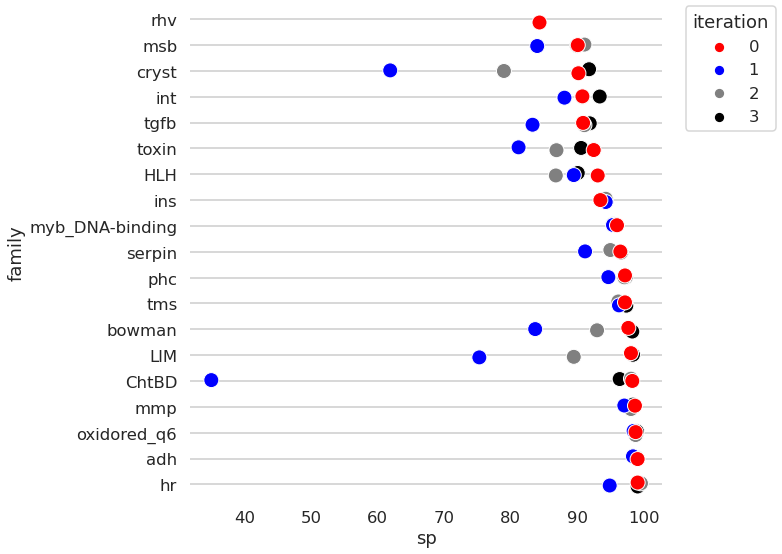

In [236]:
#plot = plt.scatter(df["family"], df["corr"], c=df["sp_3D"], cmap='Reds')
#plt.clf()
#cbar = plt.colorbar(plot)
#cbar.set_label('sp_3D', rotation=270)
sns.set_theme(style="whitegrid")
sns.set_context("talk")

tcs_wf_summary_3D_prob = tcs_wf_summary_3D_prob.sort_values(by = "iteration", ascending = False)


sorter = tcs_wf_summary_3D_prob[tcs_wf_summary_3D_prob.iteration == 0].sort_values("sp").family.to_frame()
tcs_wf_summary_3D_prob_sorted = pd.merge(sorter,tcs_wf_summary_3D_prob, on = "family", how = 'left')

# Create an array with the colors you want to use
colors = list(itertools.chain.from_iterable([["red", "blue", "grey", "black", "grey", "grey"],["orange"]*100]))

#colors = ["red", "blue", "grey", "black", "grey", "grey", rep(c("orag"))]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))


g = sns.PairGrid(tcs_wf_summary_3D_prob_sorted,
                 x_vars="sp", y_vars=["family"], hue = "iteration",
                 height=8, aspect=1)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=True,
       linewidth=1, edgecolor="w")


for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "iteration")

